# Early Detection of Autism Spectrum Disorder Using Deep Learning

In [161]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tensorflow.keras.utils import plot_model

# 1. Autism Spectrum: Adult Dataset

In [162]:
# Import Data
df = pd.read_csv('/content/autism_screening.csv')

## I. Data Preprocessing

In [163]:
# Checking for the target variable distribution
fig = px.pie(data_frame = df, names = 'austim', hole = 0.5, title = 'Yes vs No', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Turbo)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

<ipython-input-164-93ddb8500e40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



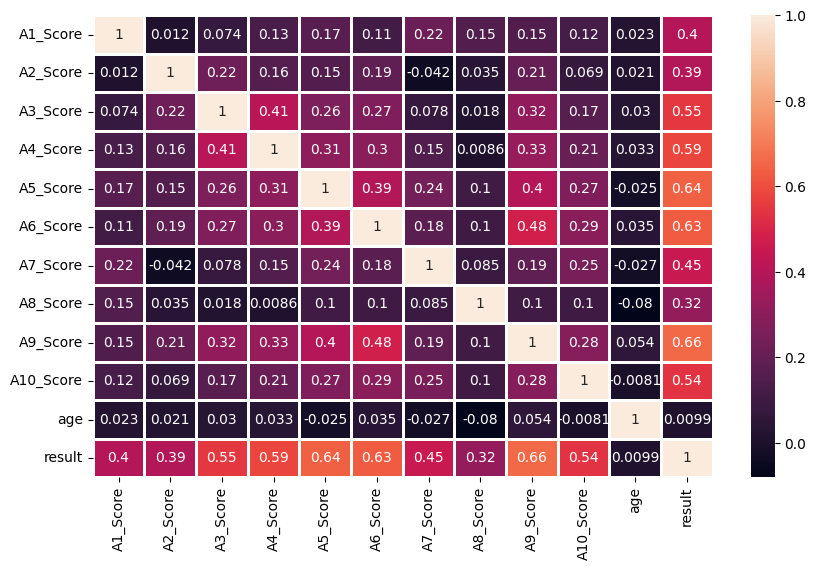

In [164]:
#Correlation plot
plt.figure(figsize = (10, 6))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [165]:
df = df.dropna(subset=['age'])

In [166]:
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

<ipython-input-166-653e8a25d312>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [167]:
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


In [168]:
# Specify the column and the string to count
column_name = ['ethnicity', 'relation','age']
string_to_count = '?'

# Count the occurrences of the string in the column
for i in column_name:
  count = (df[i] == string_to_count).sum()
  print(count)

93
93
0


In [169]:
column_name = 'ethnicity'
column_name2 = 'relation'

mode_value = df[column_name].mode()[0]
mode_value2 = df[column_name].mode()[0]

# Replace the specific string with the mode of the column
df.ethnicity = df.ethnicity.replace('?', mode_value)
df.age = df.age.replace('?', mode_value)
df.relation = df.relation.replace('others', 'Others')
df.ethnicity = df.ethnicity.replace('others', 'Others')
df.relation = df.relation.replace('?', mode_value)
df.ethnicity = df.ethnicity.replace("'Middle Eastern '", 'Middle Eastern' )
df.ethnicity = df.ethnicity.replace('Middle Eastern ','Middle Eastern')
df.ethnicity = df.ethnicity.replace("'South Asian'",'South Asian')
df.relation = df.relation.replace("'Health care professional'", 'Health care professional')
df.relation = df.relation.replace('self', 'Self')
df.age_desc = df.age_desc.replace("'12-15 years'", "'12-16 years'")

<ipython-input-169-bf976dbf470a>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [170]:
# Split the dataset into features and target variable
X = df.drop('austim', axis=1)
y = df['austim']

In [171]:
X = X.drop(columns=['age','result','contry_of_res','Class/ASD'])

In [172]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ethnicity','relation','gender','jundice','used_app_before','age_desc'])

In [173]:
X = X.astype(int)

In [174]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 0 to 703
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   A1_Score                           702 non-null    int64
 1   A2_Score                           702 non-null    int64
 2   A3_Score                           702 non-null    int64
 3   A4_Score                           702 non-null    int64
 4   A5_Score                           702 non-null    int64
 5   A6_Score                           702 non-null    int64
 6   A7_Score                           702 non-null    int64
 7   A8_Score                           702 non-null    int64
 8   A9_Score                           702 non-null    int64
 9   A10_Score                          702 non-null    int64
 10  ethnicity_Asian                    702 non-null    int64
 11  ethnicity_Black                    702 non-null    int64
 12  ethnicity_Hispanic    

In [175]:
# Random-Oversampling

a1=X
b1=y

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority")

X, y = ros.fit_resample(a1, b1)

X.shape[0] - a1.shape[0]

520

## II. Standardizing and Splitting the Dataset

In [176]:
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [177]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [178]:
import tensorflow as tf
from tensorflow import keras

In [179]:
# Convert the datasets to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [180]:
# Batch and shuffle the datasets
batch_size = 10
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## III. Base Neural Network Model

In [181]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [182]:
#Input Size
X_train.shape[1]

33

In [183]:
# Define the model architecture
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

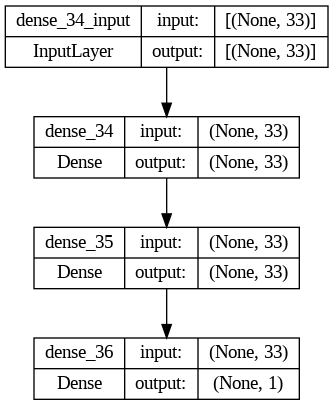

In [184]:
plot_model(model, to_file='model.png', show_shapes=True)

In [185]:
# Compile model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [186]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_dataset, 
                    validation_data=val_dataset, epochs=150, callbacks=[early_stop])

Epoch 1/150
79/79 [==============================] - 1s 3ms/step - loss: 0.6906 - accuracy: 0.5557 - val_loss: 0.6271 - val_accuracy: 0.6735
Epoch 2/150
79/79 [==============================] - 0s 2ms/step - loss: 0.5714 - accuracy: 0.7145 - val_loss: 0.5669 - val_accuracy: 0.7194
Epoch 3/150
79/79 [==============================] - 0s 2ms/step - loss: 0.5194 - accuracy: 0.7529 - val_loss: 0.5232 - val_accuracy: 0.7296
Epoch 4/150
79/79 [==============================] - 0s 1ms/step - loss: 0.4780 - accuracy: 0.7823 - val_loss: 0.4976 - val_accuracy: 0.7806
Epoch 5/150
79/79 [==============================] - 0s 2ms/step - loss: 0.4470 - accuracy: 0.8246 - val_loss: 0.4706 - val_accuracy: 0.8265
Epoch 6/150
79/79 [==============================] - 0s 1ms/step - loss: 0.4205 - accuracy: 0.8259 - val_loss: 0.4520 - val_accuracy: 0.8316
Epoch 7/150
79/79 [==============================] - 0s 2ms/step - loss: 0.3946 - accuracy: 0.8412 - val_loss: 0.4340 - val_accuracy: 0.8265
Epoch 8/150
7

Evaluating the model:

In [187]:
#Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

7/7 [==============================] - 0s 2ms/step - loss: 0.2381 - accuracy: 0.9286
Val Loss: 0.23805102705955505
Val Accuracy: 0.9285714030265808


In [188]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 0s 2ms/step - loss: 0.2087 - accuracy: 0.9306
Test Loss: 0.2086716741323471
Test Accuracy: 0.9306122660636902


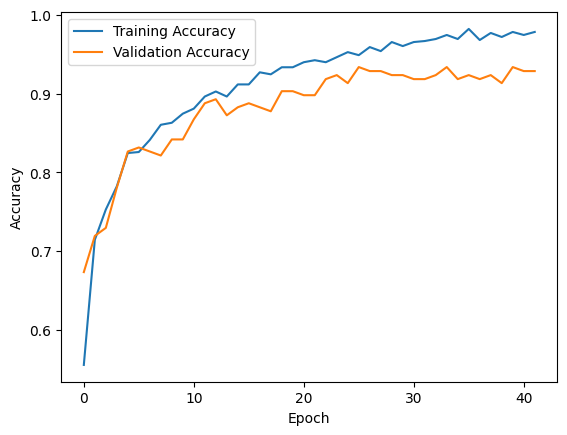

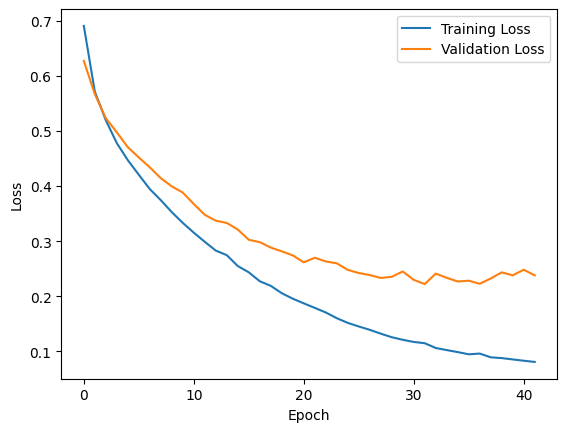

In [189]:
import matplotlib.pyplot as plt

# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## IV. Improved Network Architecture

In [190]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(512, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.03)))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

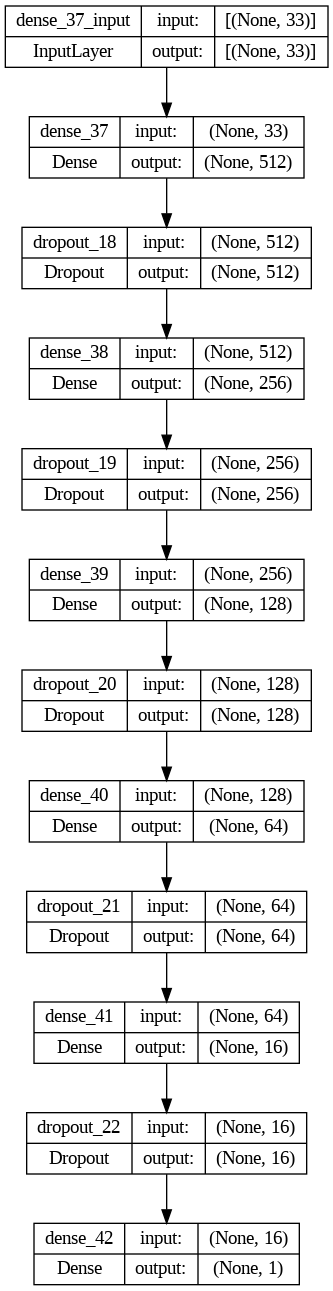

In [191]:
plot_model(model2, to_file='model.png', show_shapes=True)

In [192]:
# Compile model
model2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0009,
    beta_1=0.9,
    beta_2=0.999,
    epsilon= 1e-07,
    amsgrad=False,
    weight_decay= 1e-6,
    use_ema = True,
    ema_momentum = 0.99,
    ema_overwrite_frequency = 10,
    jit_compile=True,
    ),loss='binary_crossentropy', metrics=['accuracy'])

In [193]:
early_stop = EarlyStopping(patience=20, verbose=1)
history = model2.fit(train_dataset, 
                    validation_data=val_dataset, epochs=250, 
                    batch_size=10)

Epoch 1/250
79/79 [==============================] - 2s 7ms/step - loss: 2.3373 - accuracy: 0.5352 - val_loss: 2.1424 - val_accuracy: 0.5969
Epoch 2/250
79/79 [==============================] - 0s 4ms/step - loss: 2.2100 - accuracy: 0.5570 - val_loss: 2.0455 - val_accuracy: 0.6429
Epoch 3/250
79/79 [==============================] - 0s 4ms/step - loss: 2.0871 - accuracy: 0.6095 - val_loss: 1.9592 - val_accuracy: 0.6071
Epoch 4/250
79/79 [==============================] - 0s 5ms/step - loss: 1.9808 - accuracy: 0.6210 - val_loss: 1.8838 - val_accuracy: 0.6224
Epoch 5/250
79/79 [==============================] - 0s 5ms/step - loss: 1.8674 - accuracy: 0.6492 - val_loss: 1.8048 - val_accuracy: 0.6735
Epoch 6/250
79/79 [==============================] - 0s 4ms/step - loss: 1.7730 - accuracy: 0.6786 - val_loss: 1.7318 - val_accuracy: 0.7092
Epoch 7/250
79/79 [==============================] - 0s 5ms/step - loss: 1.6858 - accuracy: 0.7017 - val_loss: 1.6641 - val_accuracy: 0.7194
Epoch 8/250
7

## V. Model Evaluation

In [194]:
#Evaluate model on validation set
val_loss, val_acc = model2.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

7/7 [==============================] - 0s 3ms/step - loss: 0.2664 - accuracy: 0.9388
Val Loss: 0.2664145231246948
Val Accuracy: 0.9387755393981934


In [195]:
nn_accuracy_test = max(history.history['val_accuracy'])
print("Test Accuracy is:",nn_accuracy_test)

Test Accuracy is: 0.9642857313156128


In [196]:
# Evaluate model on test set
test_loss, test_acc = model2.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 0s 3ms/step - loss: 0.4167 - accuracy: 0.9102
Test Loss: 0.41666221618652344
Test Accuracy: 0.9102040529251099


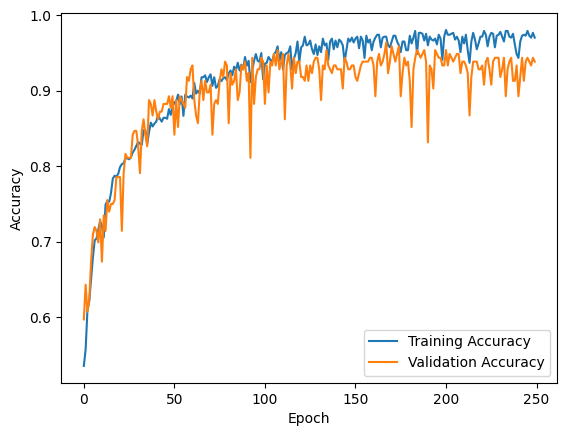

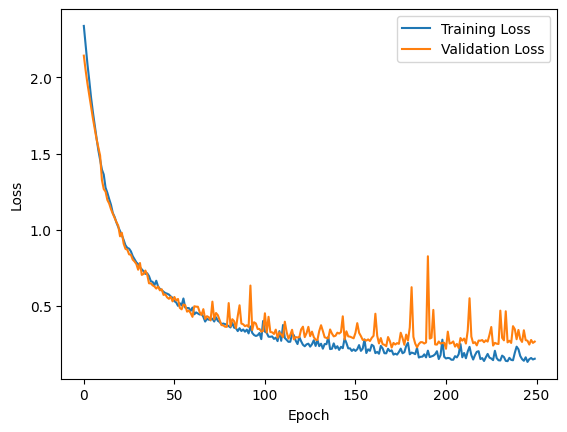

In [197]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [198]:
import numpy as np 

y_pred = model2.predict(X_test)

y_pred = np.round(y_pred)

8/8 [==============================] - 0s 4ms/step


In [199]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       125
           1       0.85      1.00      0.92       120

    accuracy                           0.91       245
   macro avg       0.92      0.91      0.91       245
weighted avg       0.92      0.91      0.91       245



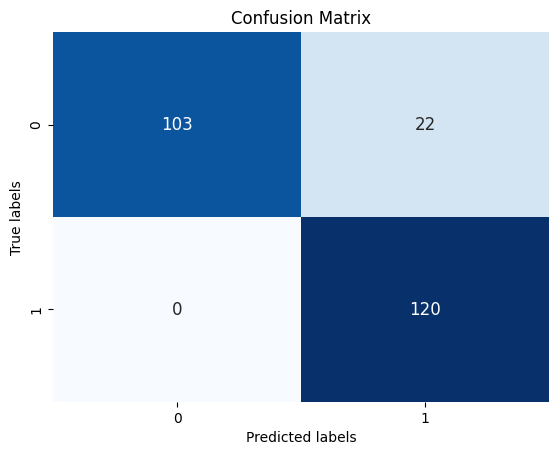

In [200]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize":12})

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Misclassification Rate = 0.1020

#Autism Spectrum: Adolescent

In [201]:
# Import Data
df = pd.read_csv('/content/adol_dataset_clean.csv')

## I. Data Preprocessing 

In [202]:
# Checking for the target variable distribution
fig = px.pie(data_frame = df, names = 'austim', hole = 0.5, title = 'Yes vs No', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Turbo)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

<ipython-input-203-93ddb8500e40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



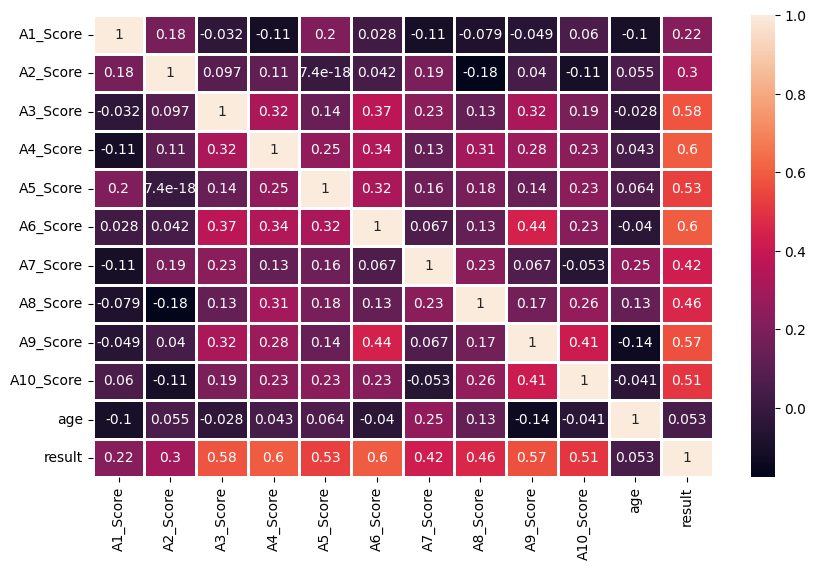

In [203]:
#Correlation plot
plt.figure(figsize = (10, 6))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [204]:
df = df.dropna(subset=['age'])
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

In [205]:
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


In [206]:
# Specify the column and the string to count
column_name = ['ethnicity', 'relation','age']
string_to_count = '?'

# Count the occurrences of the string in the column
for i in column_name:
  count = (df[i] == string_to_count).sum()
  print(count)

0
0
0


In [207]:
column_name = 'ethnicity'
column_name2 = 'relation'

mode_value = df[column_name].mode()[0]
mode_value2 = df[column_name].mode()[0]

# Replace the specific string with the mode of the column
df.ethnicity = df.ethnicity.replace('?', mode_value)
df.age = df.age.replace('?', mode_value)
df.relation = df.relation.replace('others', 'Others')
df.ethnicity = df.ethnicity.replace('others', 'Others')
df.relation = df.relation.replace('?', mode_value)
df.ethnicity = df.ethnicity.replace("'Middle Eastern '", 'Middle Eastern' )
df.ethnicity = df.ethnicity.replace('Middle Eastern ','Middle Eastern')
df.ethnicity = df.ethnicity.replace("'South Asian'",'South Asian')
df.relation = df.relation.replace("'Health care professional'", 'Health care professional')
df.relation = df.relation.replace('self', 'Self')
df.age_desc = df.age_desc.replace("'12-15 years'", "'12-16 years'")

In [208]:
# Split the dataset into features and target variable
X = df.drop('austim', axis=1)
y = df['austim']

In [209]:
X = X.drop(columns=['age','result','contry_of_res','Class/ASD'])

In [210]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ethnicity','relation','gender','jundice','used_app_before','age_desc'])

In [211]:
X = X.astype(int)

In [212]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   A1_Score                           104 non-null    int64
 1   A2_Score                           104 non-null    int64
 2   A3_Score                           104 non-null    int64
 3   A4_Score                           104 non-null    int64
 4   A5_Score                           104 non-null    int64
 5   A6_Score                           104 non-null    int64
 6   A7_Score                           104 non-null    int64
 7   A8_Score                           104 non-null    int64
 8   A9_Score                           104 non-null    int64
 9   A10_Score                          104 non-null    int64
 10  ethnicity_Asian                    104 non-null    int64
 11  ethnicity_Black                    104 non-null    int64
 12  ethnicity_Hispanic    

In [213]:
# Random-Oversampling

a1=X
b1=y

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority")

X, y = ros.fit_resample(a1, b1)

X.shape[0] - a1.shape[0]

76

## II. Standardizing and Splitting the Dataset


In [214]:
# Scale the input features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [215]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [216]:
# Convert the datasets to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [217]:
# Batch and shuffle the datasets
batch_size = 10
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## III. Base Neural Network Model

In [218]:
#Input Size
X_train.shape[1]

31

In [219]:
# Define the model architecture
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

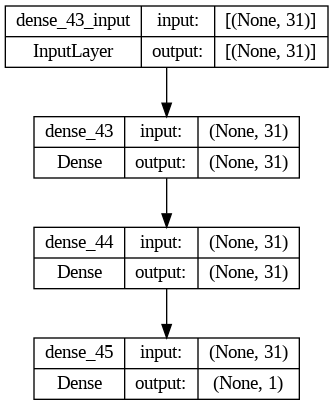

In [220]:
plot_model(model, to_file='model.png', show_shapes=True)

In [221]:
# Compile model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [222]:
early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_dataset, 
                    validation_data=val_dataset, epochs=150, callbacks=[early_stop])

Epoch 1/150
12/12 [==============================] - 1s 11ms/step - loss: 0.7684 - accuracy: 0.4783 - val_loss: 0.7355 - val_accuracy: 0.4138
Epoch 2/150
12/12 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5304 - val_loss: 0.6862 - val_accuracy: 0.3793
Epoch 3/150
12/12 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.5478 - val_loss: 0.6459 - val_accuracy: 0.4828
Epoch 4/150
12/12 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.7217 - val_loss: 0.6139 - val_accuracy: 0.5862
Epoch 5/150
12/12 [==============================] - 0s 2ms/step - loss: 0.5483 - accuracy: 0.7739 - val_loss: 0.5837 - val_accuracy: 0.6552
Epoch 6/150
12/12 [==============================] - 0s 3ms/step - loss: 0.5087 - accuracy: 0.8522 - val_loss: 0.5558 - val_accuracy: 0.6552
Epoch 7/150
12/12 [==============================] - 0s 3ms/step - loss: 0.4710 - accuracy: 0.8522 - val_loss: 0.5290 - val_accuracy: 0.6552
Epoch 8/150


Evaluating the model

In [223]:
#Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

1/1 [==============================] - 0s 295ms/step - loss: 0.1334 - accuracy: 0.9310
Val Loss: 0.13344796001911163
Val Accuracy: 0.931034505367279


In [224]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2/2 [==============================] - 0s 6ms/step - loss: 0.1849 - accuracy: 0.9722
Test Loss: 0.1849435418844223
Test Accuracy: 0.9722222089767456


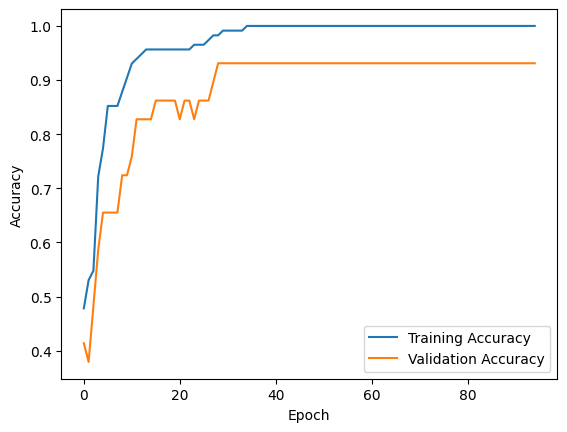

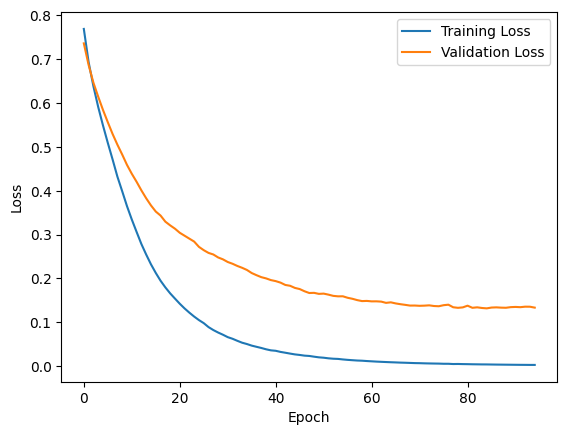

In [225]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## IV. Improved Network Architecture 

In [226]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(31, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.03)))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

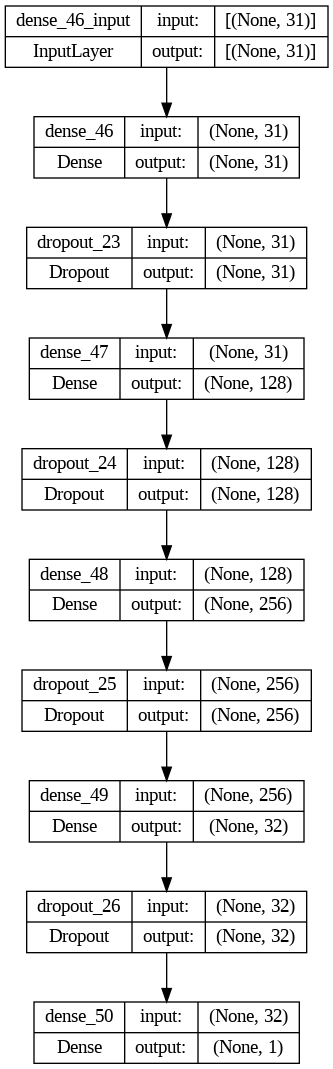

In [227]:
plot_model(model2, to_file='model.png', show_shapes=True)

In [228]:
# Compile model
model2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon= 1e-07,
    amsgrad=False,
    weight_decay= 1e-6,
    use_ema = True,
    ema_momentum = 0.8,
    ema_overwrite_frequency = 10,
    jit_compile=True,
    ),loss='binary_crossentropy', metrics=['accuracy'])

In [229]:
early_stop = EarlyStopping(patience=20, verbose=1)
history = model2.fit(train_dataset, 
                    validation_data=val_dataset, epochs=250, 
                    batch_size=8)

Epoch 1/250
12/12 [==============================] - 2s 23ms/step - loss: 1.6243 - accuracy: 0.5130 - val_loss: 1.5883 - val_accuracy: 0.5517
Epoch 2/250
12/12 [==============================] - 0s 8ms/step - loss: 1.5865 - accuracy: 0.5391 - val_loss: 1.5564 - val_accuracy: 0.6207
Epoch 3/250
12/12 [==============================] - 0s 4ms/step - loss: 1.5319 - accuracy: 0.5826 - val_loss: 1.5243 - val_accuracy: 0.5862
Epoch 4/250
12/12 [==============================] - 0s 5ms/step - loss: 1.5078 - accuracy: 0.6261 - val_loss: 1.4953 - val_accuracy: 0.5862
Epoch 5/250
12/12 [==============================] - 0s 4ms/step - loss: 1.4773 - accuracy: 0.6435 - val_loss: 1.4747 - val_accuracy: 0.7241
Epoch 6/250
12/12 [==============================] - 0s 4ms/step - loss: 1.4567 - accuracy: 0.6870 - val_loss: 1.4437 - val_accuracy: 0.6552
Epoch 7/250
12/12 [==============================] - 0s 5ms/step - loss: 1.4202 - accuracy: 0.6870 - val_loss: 1.4108 - val_accuracy: 0.6552
Epoch 8/250


## V. Model Evaluation

In [230]:
#Evaluate model on validation set
val_loss, val_acc = model2.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

1/1 [==============================] - 0s 324ms/step - loss: 0.2566 - accuracy: 0.9655
Val Loss: 0.2565685212612152
Val Accuracy: 0.9655172228813171


In [231]:
# Evaluate model on test set
test_loss, test_acc = model2.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2/2 [==============================] - 0s 7ms/step - loss: 0.0848 - accuracy: 1.0000
Test Loss: 0.08479328453540802
Test Accuracy: 1.0


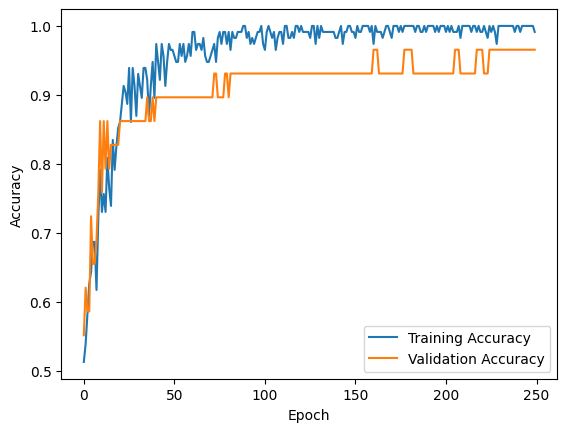

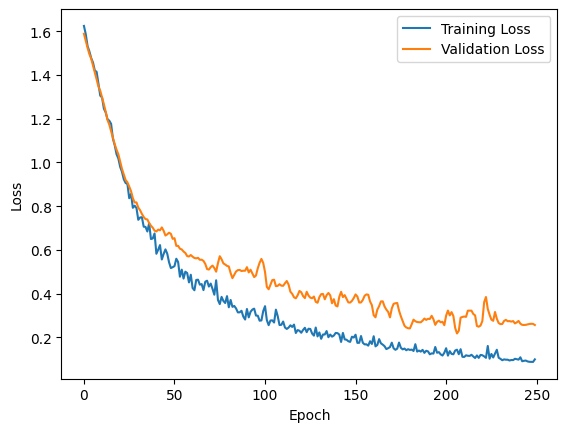

In [232]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [233]:
y_pred = model2.predict(X_test)
y_pred = np.round(y_pred)

2/2 [==============================] - 0s 5ms/step


In [234]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



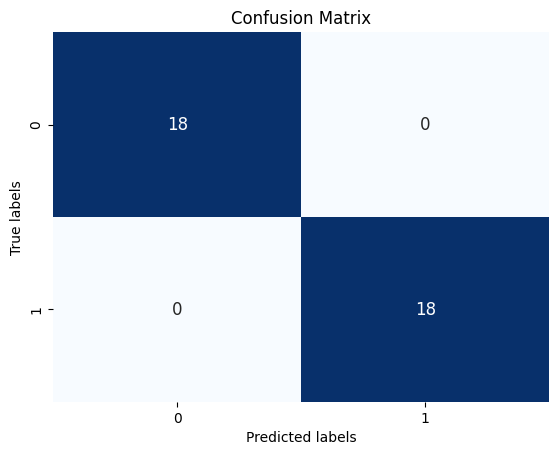

In [235]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize":12})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Misclassification Rate = 0.0278

#Autism Spectrum: Toddlers

In [236]:
# Import Data
df = pd.read_csv('/content/child_dataset_clean.csv')

## I. Data Preprocessing

In [237]:
# Checking for the target variable distribution
fig = px.pie(data_frame = df, names = 'austim', hole = 0.5, title = 'Yes vs No', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Turbo)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

<ipython-input-238-93ddb8500e40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



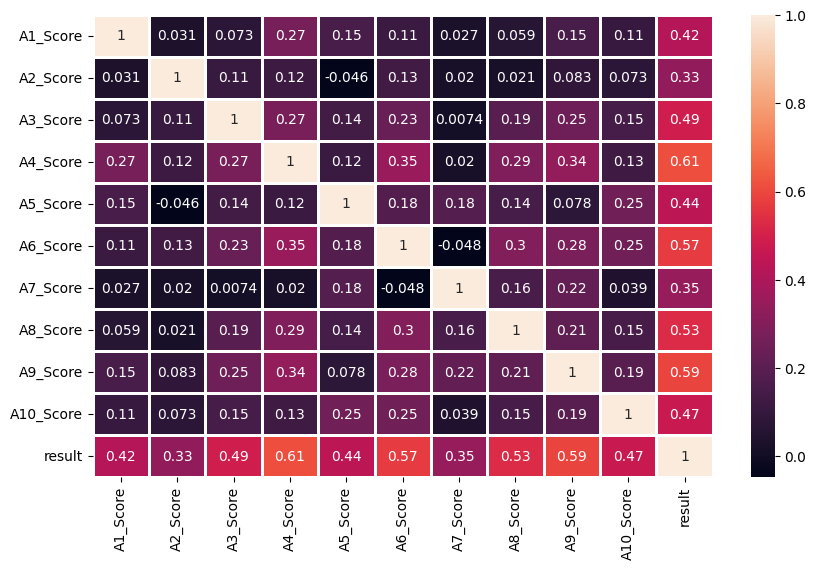

In [238]:
#Correlation plot
plt.figure(figsize = (10, 6))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [239]:
df = df.dropna(subset=['age'])
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

In [240]:
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


In [241]:
# Specify the column and the string to count
column_name = ['ethnicity', 'relation','age']
string_to_count = '?'

# Count the occurrences of the string in the column
for i in column_name:
  count = (df[i] == string_to_count).sum()
  print(count)

0
0
4


In [242]:
column_name = 'ethnicity'
column_name2 = 'relation'

mode_value = df[column_name].mode()[0]
mode_value2 = df[column_name].mode()[0]

# Replace the specific string with the mode of the column
df.ethnicity = df.ethnicity.replace('?', mode_value)
df.age = df.age.replace('?', mode_value)
df.relation = df.relation.replace('others', 'Others')
df.ethnicity = df.ethnicity.replace('others', 'Others')
df.relation = df.relation.replace('?', mode_value)
df.ethnicity = df.ethnicity.replace("'Middle Eastern '", 'Middle Eastern' )
df.ethnicity = df.ethnicity.replace('Middle Eastern ','Middle Eastern')
df.ethnicity = df.ethnicity.replace("'South Asian'",'South Asian')
df.relation = df.relation.replace("'Health care professional'", 'Health care professional')
df.relation = df.relation.replace('self', 'Self')
df.age_desc = df.age_desc.replace("'12-15 years'", "'12-16 years'")

In [243]:
# Split the dataset into features and target variable
X = df.drop('austim', axis=1)
y = df['austim']

In [244]:
X = X.drop(columns=['age','result','contry_of_res','Class/ASD'])

In [245]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ethnicity','relation','gender','jundice','used_app_before','age_desc'])

In [246]:
X = X.astype(int)

In [247]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   A1_Score                           292 non-null    int64
 1   A2_Score                           292 non-null    int64
 2   A3_Score                           292 non-null    int64
 3   A4_Score                           292 non-null    int64
 4   A5_Score                           292 non-null    int64
 5   A6_Score                           292 non-null    int64
 6   A7_Score                           292 non-null    int64
 7   A8_Score                           292 non-null    int64
 8   A9_Score                           292 non-null    int64
 9   A10_Score                          292 non-null    int64
 10  ethnicity_Asian                    292 non-null    int64
 11  ethnicity_Black                    292 non-null    int64
 12  ethnicity_Hispanic    

In [248]:
# Random-Oversampling

a1=X
b1=y

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority")

X, y = ros.fit_resample(a1, b1)

X.shape[0] - a1.shape[0]

194

## II. Standardizing and Splitting the Dataset

In [249]:
# Scale the input features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [250]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [251]:
# Convert the datasets to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [252]:
# Batch and shuffle the datasets
batch_size = 10
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## III. Base Neural Network Model

In [253]:
#Input Size
X_train.shape[1]

32

In [254]:
# Define the model architecture
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

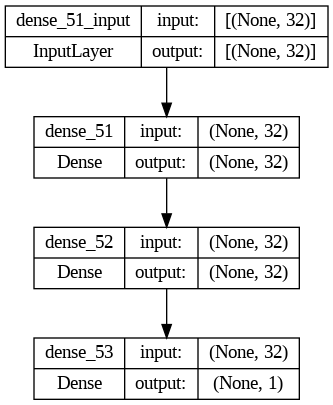

In [255]:
plot_model(model, to_file='model.png', show_shapes=True)

In [256]:
# Compile model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [257]:
early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_dataset, 
                    validation_data=val_dataset, epochs=150, callbacks=[early_stop])

Epoch 1/150
31/31 [==============================] - 1s 6ms/step - loss: 0.6777 - accuracy: 0.5484 - val_loss: 0.6652 - val_accuracy: 0.6026
Epoch 2/150
31/31 [==============================] - 0s 4ms/step - loss: 0.6164 - accuracy: 0.6839 - val_loss: 0.6309 - val_accuracy: 0.6795
Epoch 3/150
31/31 [==============================] - 0s 3ms/step - loss: 0.5755 - accuracy: 0.7226 - val_loss: 0.6121 - val_accuracy: 0.6923
Epoch 4/150
31/31 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.7516 - val_loss: 0.5847 - val_accuracy: 0.7308
Epoch 5/150
31/31 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.8226 - val_loss: 0.5678 - val_accuracy: 0.7308
Epoch 6/150
31/31 [==============================] - 0s 2ms/step - loss: 0.4808 - accuracy: 0.8161 - val_loss: 0.5578 - val_accuracy: 0.7308
Epoch 7/150
31/31 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.8387 - val_loss: 0.5502 - val_accuracy: 0.7308
Epoch 8/150
3

Evaluating the model

In [258]:
#Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

3/3 [==============================] - 0s 5ms/step - loss: 0.5331 - accuracy: 0.8718
Val Loss: 0.5330847501754761
Val Accuracy: 0.8717948794364929


In [259]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

4/4 [==============================] - 0s 2ms/step - loss: 0.4023 - accuracy: 0.8469
Test Loss: 0.40228134393692017
Test Accuracy: 0.8469387888908386


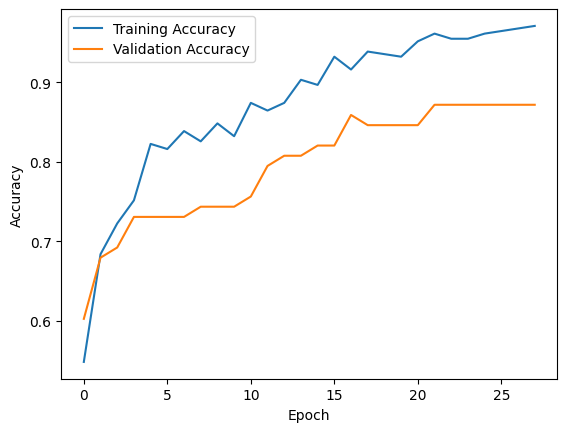

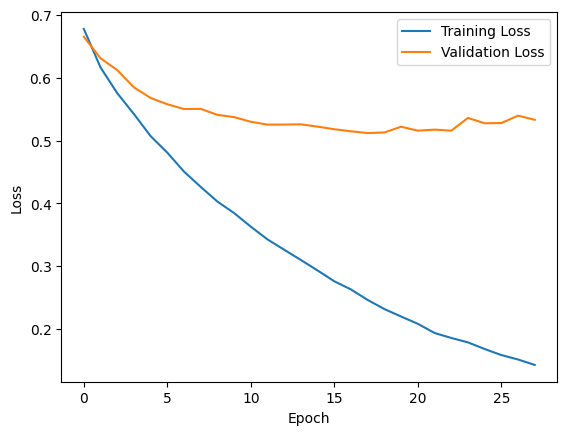

In [260]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## IV. Improved Network Architecture

In [261]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(32, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.01)))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

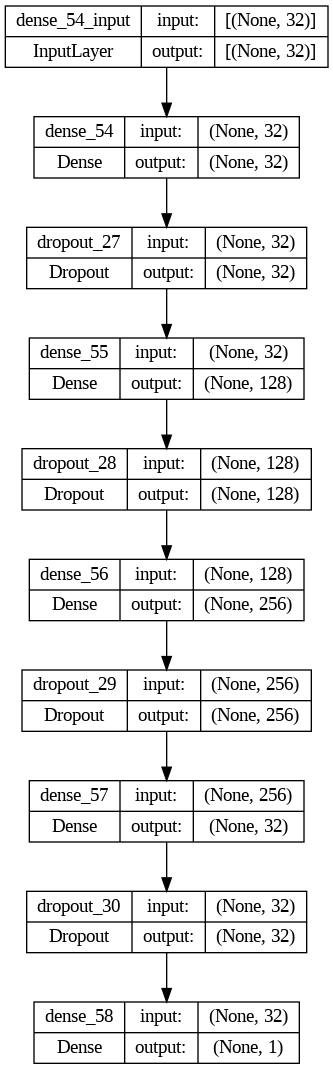

In [262]:
plot_model(model2, to_file='model.png', show_shapes=True)

In [263]:
# Compile model
model2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0008,
    beta_1=0.9,
    beta_2=0.999,
    epsilon= 1e-07,
    amsgrad=False,
    weight_decay= 1e-6,
    use_ema = True,
    ema_momentum = 0.9,
    ema_overwrite_frequency = 10,
    jit_compile=True,
    ),loss='binary_crossentropy', metrics=['accuracy'])

In [264]:
early_stop = EarlyStopping(patience=20, verbose=1)
history = model2.fit(train_dataset, 
                    validation_data=test_dataset, epochs=200, 
                    batch_size=16)

Epoch 1/200
31/31 [==============================] - 1s 6ms/step - loss: 0.9933 - accuracy: 0.5355 - val_loss: 0.9799 - val_accuracy: 0.5102
Epoch 2/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9446 - accuracy: 0.5710 - val_loss: 0.9590 - val_accuracy: 0.5408
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 0.9296 - accuracy: 0.5935 - val_loss: 0.9204 - val_accuracy: 0.5918
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 0.8917 - accuracy: 0.6581 - val_loss: 0.8968 - val_accuracy: 0.5510
Epoch 5/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8877 - accuracy: 0.6032 - val_loss: 0.8776 - val_accuracy: 0.5918
Epoch 6/200
31/31 [==============================] - 0s 3ms/step - loss: 0.8553 - accuracy: 0.6806 - val_loss: 0.8591 - val_accuracy: 0.5714
Epoch 7/200
31/31 [==============================] - 0s 2ms/step - loss: 0.8142 - accuracy: 0.7065 - val_loss: 0.8384 - val_accuracy: 0.5816
Epoch 8/200
3

## V. Model Evaluation

In [265]:
#Evaluate model on validation set
val_loss, val_acc = model2.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

3/3 [==============================] - 0s 4ms/step - loss: 0.9590 - accuracy: 0.8718
Val Loss: 0.9589979648590088
Val Accuracy: 0.8717948794364929


In [266]:
nn_accuracy_test = max(history.history['val_accuracy'])
print("Test Accuracy is:",nn_accuracy_test)

Test Accuracy is: 0.918367326259613


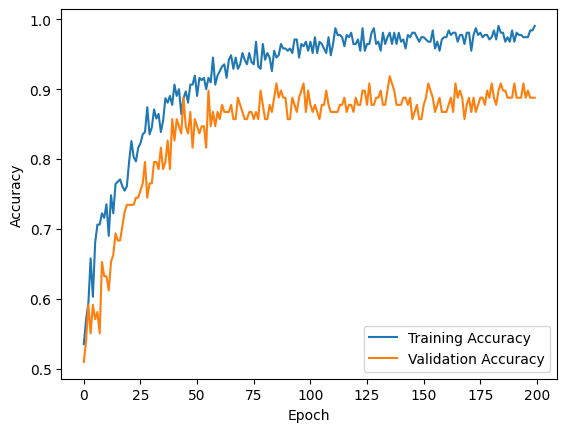

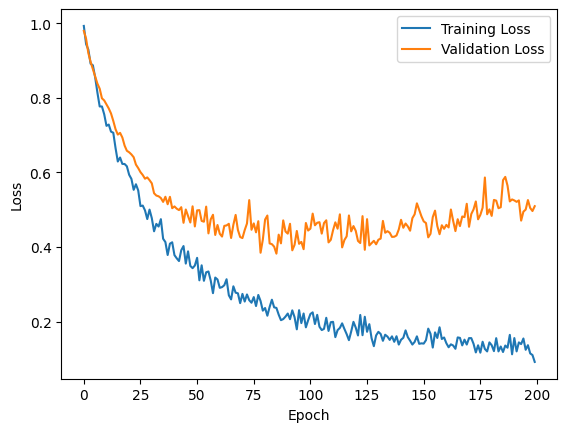

In [267]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [268]:
y_pred = model2.predict(X_test)
y_pred = np.round(y_pred)

4/4 [==============================] - 0s 2ms/step


In [269]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        44
           1       0.88      0.93      0.90        54

    accuracy                           0.89        98
   macro avg       0.89      0.88      0.89        98
weighted avg       0.89      0.89      0.89        98



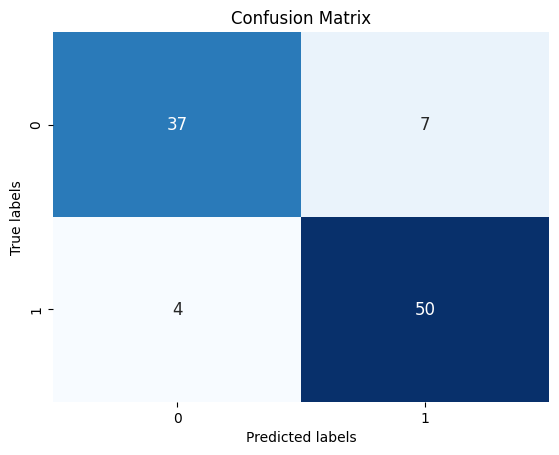

In [270]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize":12})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Misclassification Rate = 0.1020

#Combined Age Group: Autism Spectrum Screening 

In [271]:
import pandas as pd

# Load the datasets
df1 = pd.read_csv('/content/autism_screening.csv')
df2 = pd.read_csv('/content/adol_dataset_clean.csv')
df3 = pd.read_csv('/content/child_dataset_clean.csv')

# Concatenate the datasets vertically
df = pd.concat([df1, df2, df3], axis=0)

# Reset the index of the concatenated DataFrame
df = df.reset_index(drop=True)

## I. Data Preprocessing

In [272]:
# Checking for the target variable distribution
fig = px.pie(data_frame = df, names = 'austim', hole = 0.5, title = 'Yes vs No', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Turbo)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

<ipython-input-273-93ddb8500e40>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



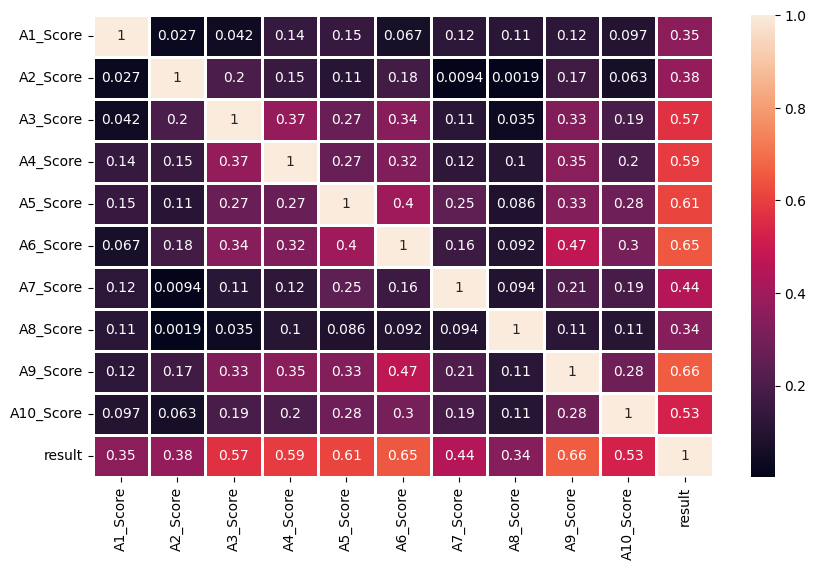

In [273]:
#Correlation plot
plt.figure(figsize = (10, 6))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

In [274]:
df = df.dropna(subset=['age'])

In [275]:
df['austim'] = df['austim'].map({'yes': 1, 'no': 0})

<ipython-input-275-653e8a25d312>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [276]:
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64


In [277]:
# Specify the column and the string to count
column_name = ['ethnicity', 'relation','age']
string_to_count = '?'

# Count the occurrences of the string in the column
for i in column_name:
  count = (df[i] == string_to_count).sum()
  print(count)

93
93
4


In [278]:
column_name = 'ethnicity'
column_name2 = 'relation'

mode_value = df[column_name].mode()[0]
mode_value2 = df[column_name].mode()[0]

# Replace the specific string with the mode of the column
df.ethnicity = df.ethnicity.replace('?', mode_value)
df.age = df.age.replace('?', mode_value)
df.relation = df.relation.replace('others', 'Others')
df.ethnicity = df.ethnicity.replace('others', 'Others')
df.relation = df.relation.replace('?', mode_value)
df.ethnicity = df.ethnicity.replace("'Middle Eastern '", 'Middle Eastern' )
df.ethnicity = df.ethnicity.replace('Middle Eastern ','Middle Eastern')
df.ethnicity = df.ethnicity.replace("'South Asian'",'South Asian')
df.relation = df.relation.replace("'Health care professional'", 'Health care professional')
df.relation = df.relation.replace('self', 'Self')
df.age_desc = df.age_desc.replace("'12-15 years'", "'12-16 years'")

<ipython-input-278-bf976dbf470a>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-278-bf976dbf470a>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-278-bf976dbf470a>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-278-bf

In [279]:
# Split the dataset into features and target variable
X = df.drop('austim', axis=1)
y = df['austim']

In [280]:
X = X.drop(columns=['age','result','contry_of_res','Class/ASD'])

In [281]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['ethnicity','relation','gender','jundice','used_app_before','age_desc'])

In [282]:
X = X.astype(int)

In [283]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1099
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   A1_Score                           1098 non-null   int64
 1   A2_Score                           1098 non-null   int64
 2   A3_Score                           1098 non-null   int64
 3   A4_Score                           1098 non-null   int64
 4   A5_Score                           1098 non-null   int64
 5   A6_Score                           1098 non-null   int64
 6   A7_Score                           1098 non-null   int64
 7   A8_Score                           1098 non-null   int64
 8   A9_Score                           1098 non-null   int64
 9   A10_Score                          1098 non-null   int64
 10  ethnicity_Asian                    1098 non-null   int64
 11  ethnicity_Black                    1098 non-null   int64
 12  ethnicity_Hispanic  

In [284]:
# Random-Oversampling

a1=X
b1=y

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority")

X, y = ros.fit_resample(a1, b1)

X.shape[0] - a1.shape[0]

790

## II. Standardizing and Splitting the Dataset

In [285]:
# Scale the input features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [286]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [287]:
# Convert the datasets to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [288]:
# Batch and shuffle the datasets
batch_size = 10
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## III. Base Neural Network Model

In [289]:
#Input Size
X_train.shape[1]

35

In [290]:
# Define the model architecture
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

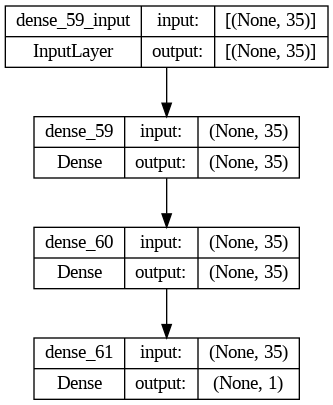

In [291]:
plot_model(model, to_file='model.png', show_shapes=True)

In [292]:
# Compile model
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [293]:
early_stop = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_dataset, 
                    validation_data=val_dataset, epochs=150, callbacks=[early_stop])

Epoch 1/150
121/121 [==============================] - 1s 2ms/step - loss: 0.6444 - accuracy: 0.6349 - val_loss: 0.6491 - val_accuracy: 0.5927
Epoch 2/150
121/121 [==============================] - 0s 2ms/step - loss: 0.5749 - accuracy: 0.7103 - val_loss: 0.6183 - val_accuracy: 0.6490
Epoch 3/150
121/121 [==============================] - 0s 2ms/step - loss: 0.5334 - accuracy: 0.7550 - val_loss: 0.6020 - val_accuracy: 0.6623
Epoch 4/150
121/121 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.7873 - val_loss: 0.5772 - val_accuracy: 0.7086
Epoch 5/150
121/121 [==============================] - 0s 2ms/step - loss: 0.4591 - accuracy: 0.8113 - val_loss: 0.5485 - val_accuracy: 0.7219
Epoch 6/150
121/121 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.8295 - val_loss: 0.5253 - val_accuracy: 0.7417
Epoch 7/150
121/121 [==============================] - 0s 2ms/step - loss: 0.3978 - accuracy: 0.8369 - val_loss: 0.5104 - val_accuracy: 0.7384

Evaluating the model

In [294]:
#Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

10/10 [==============================] - 0s 2ms/step - loss: 0.4185 - accuracy: 0.8675
Val Loss: 0.4184730350971222
Val Accuracy: 0.8675496578216553


In [295]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

12/12 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.8810
Test Loss: 0.4266209006309509
Test Accuracy: 0.8809523582458496


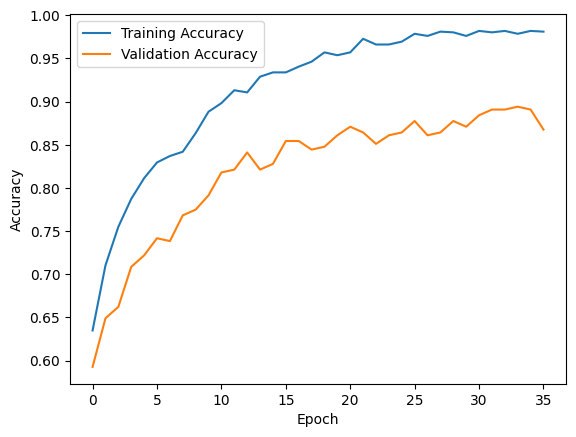

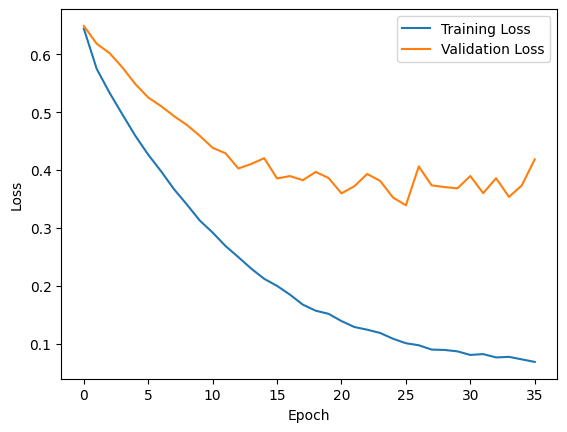

In [296]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## IV. Improved Network Architecture

In [297]:
X_train.shape[1]

35

In [298]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(512, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.03)))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

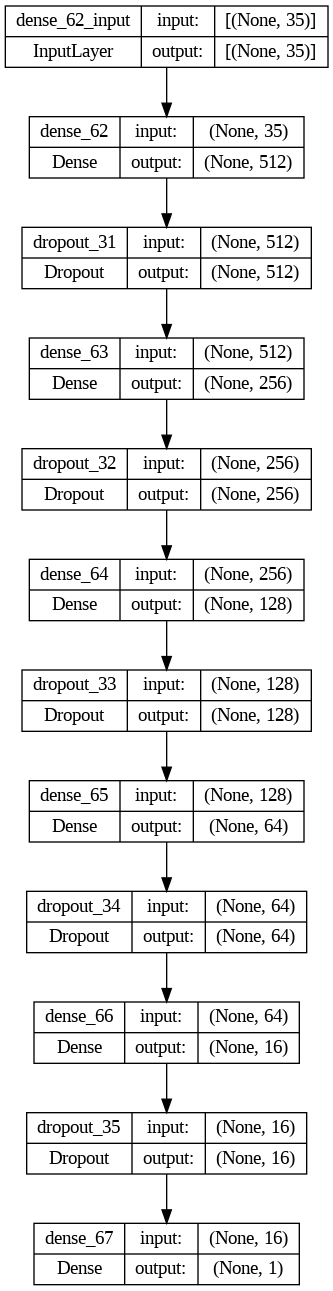

In [299]:
plot_model(model2, to_file='model.png', show_shapes=True)

In [300]:
# Compile model
model2.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0009,
    beta_1=0.9,
    beta_2=0.999,
    epsilon= 1e-07,
    amsgrad=False,
    weight_decay= 1e-6,
    use_ema = True,
    ema_momentum = 0.99,
    ema_overwrite_frequency = 10,
    jit_compile=True,
    ),loss='binary_crossentropy', metrics=['accuracy'])

In [301]:
early_stop = EarlyStopping(patience=20, verbose=1)
history = model2.fit(train_dataset, 
                    validation_data=val_dataset, epochs=250, 
                    batch_size=10)

Epoch 1/250
121/121 [==============================] - 3s 9ms/step - loss: 2.4452 - accuracy: 0.5836 - val_loss: 2.4464 - val_accuracy: 0.6258
Epoch 2/250
121/121 [==============================] - 1s 6ms/step - loss: 2.2936 - accuracy: 0.5935 - val_loss: 2.2704 - val_accuracy: 0.6192
Epoch 3/250
121/121 [==============================] - 1s 4ms/step - loss: 2.1465 - accuracy: 0.6101 - val_loss: 2.1018 - val_accuracy: 0.6391
Epoch 4/250
121/121 [==============================] - 0s 4ms/step - loss: 2.0156 - accuracy: 0.6291 - val_loss: 1.9609 - val_accuracy: 0.6358
Epoch 5/250
121/121 [==============================] - 1s 4ms/step - loss: 1.8903 - accuracy: 0.6614 - val_loss: 1.8582 - val_accuracy: 0.6358
Epoch 6/250
121/121 [==============================] - 0s 4ms/step - loss: 1.7884 - accuracy: 0.6614 - val_loss: 1.7296 - val_accuracy: 0.6589
Epoch 7/250
121/121 [==============================] - 1s 4ms/step - loss: 1.6832 - accuracy: 0.6854 - val_loss: 1.6351 - val_accuracy: 0.6490

## V. Model Evaluation

In [302]:
#Evaluate model on validation set
val_loss, val_acc = model2.evaluate(X_val, y_val)

print('Val Loss:', val_loss)
print('Val Accuracy:', val_acc)

10/10 [==============================] - 0s 4ms/step - loss: 0.4865 - accuracy: 0.9073
Val Loss: 0.48645731806755066
Val Accuracy: 0.9072847962379456


In [303]:
nn_accuracy_test = max(history.history['val_accuracy'])
print("Test Accuracy is:",nn_accuracy_test)

Test Accuracy is: 0.9139072895050049


In [304]:
# Evaluate model on test set
test_loss, test_acc = model2.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

12/12 [==============================] - 0s 2ms/step - loss: 0.5233 - accuracy: 0.8889
Test Loss: 0.5233202576637268
Test Accuracy: 0.8888888955116272


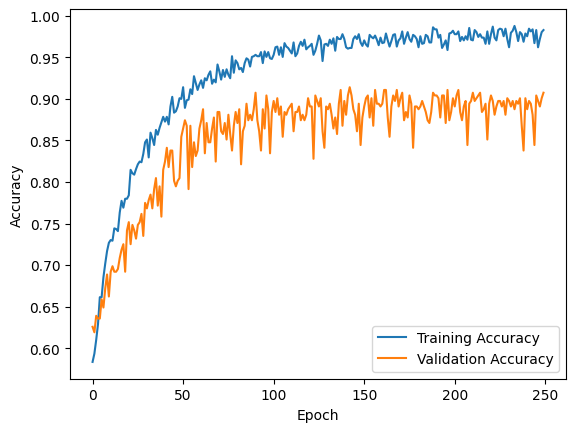

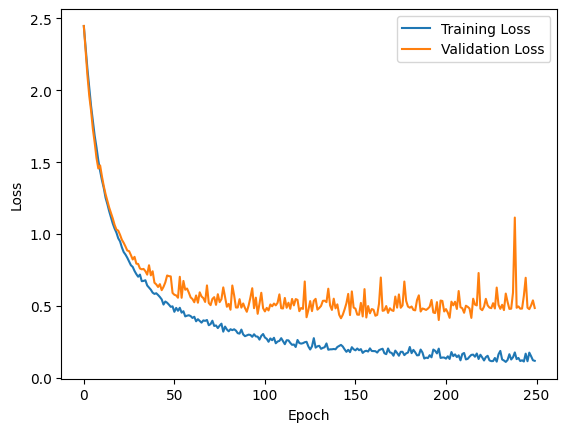

In [305]:
# Accuracy vs Epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss vs Epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [306]:
y_pred = model2.predict(X_test)
y_pred = np.round(y_pred)

12/12 [==============================] - 0s 2ms/step


In [307]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.87       183
           1       0.84      0.97      0.90       195

    accuracy                           0.89       378
   macro avg       0.90      0.89      0.89       378
weighted avg       0.90      0.89      0.89       378



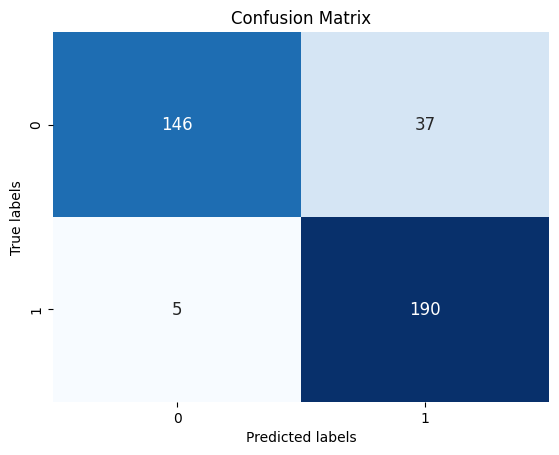

In [308]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"fontsize":12})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Misclassification Rate = 0.1190

# Summary

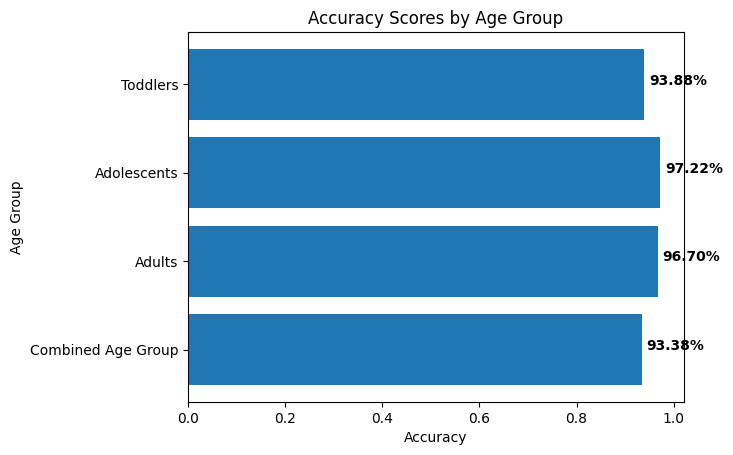

In [309]:
# Define x and y data
x = ['Toddlers', 'Adolescents', 'Adults', 'Combined Age Group']
y = [0.93877, 0.9722, 0.9670, 0.9338]

# Create a horizontal bar plot
fig, ax = plt.subplots()
ax.barh(x, y)

# Invert y-axis to show categories in descending order
ax.invert_yaxis()

# Set axis labels and title
ax.set_xlabel('Accuracy')
ax.set_ylabel('Age Group')
ax.set_title('Accuracy Scores by Age Group')

# Add percentage labels to each bar
for i, v in enumerate(y):
    ax.text(v + 0.01, i, f'{v:.2%}', color='black', fontweight='bold')

# Display the plot
plt.show()


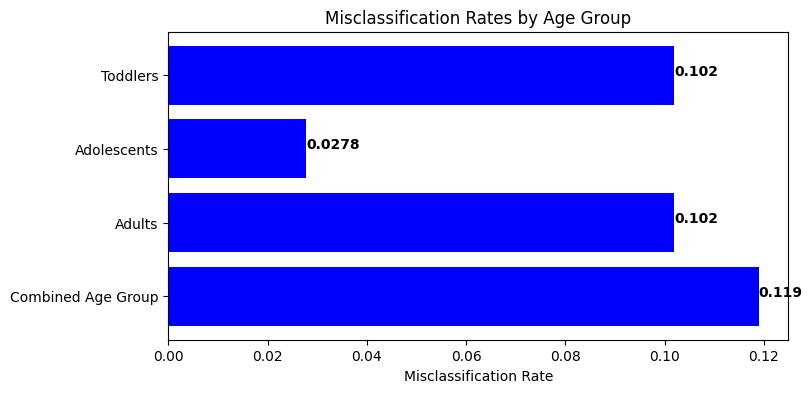

In [310]:
import matplotlib.pyplot as plt

x = ['Toddlers', 'Adolescents', 'Adults', 'Combined Age Group']
y = [0.1020, 0.0278, 0.1020, 0.1190]
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(x, y, align='center', color='blue')
ax.set_xlabel('Misclassification Rate')
ax.set_title('Misclassification Rates by Age Group')
ax.invert_yaxis()
# Add percentage labels to each bar
for i, v in enumerate(y):
    ax.text(v + 0.00001, i, f'{v}', color='black', fontweight='bold')
plt.show()